In [1073]:
#!g1.1
import numpy as np
import pandas as pd
import torch
from torchvision import datasets, transforms
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.nn.functional as func
import torch.optim as optimizer
from matplotlib import pyplot as plt
from tqdm import tqdm
import torch.nn as nn
import math
import torch.nn.functional as F
from IPython.display import clear_output

In [1074]:
#!g1.1
def KLD(x_true, p_true, x_pred, sig):
    batch_size, pNumber, _ = x_true.size()
    return 0.5 * np.log(2 * np.pi) - torch.logsumexp(p_true.view(batch_size, pNumber, 1) - net.square_dist(x_true, x_pred).squeeze(-1) / (2 * sig**2), dim=1).mean()

In [1075]:
#!g1.1
x_uni = torch.distributions.uniform.Uniform(low=0, high=1)
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

hidden_dim = 32
batch_size = 2048
num_heads = 4
x_dim = 2
pNumber = 50

read_data = np.loadtxt('particles_data.csv', delimiter=',')
xp = read_data.reshape(read_data.shape[0] // pNumber, pNumber, x_dim + 1)

x1 = torch.from_numpy(xp[:, :, :-1]).double().to(device)
p1 = torch.from_numpy(xp[:, :, -1]).double().to(device)

In [1076]:
#!g1.1

train_dataset = TensorDataset(x1[:int(0.7*len(xp))], p1[:int(0.7*len(xp))])
val_dataset = TensorDataset(x1[int(0.7*len(xp)):int(0.9*len(xp))], p1[int(0.7*len(xp)):int(0.9*len(xp))])
test_dataset = TensorDataset(x1[int(0.9*len(xp)):], p1[int(0.9*len(xp)):])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [1077]:
#!g1.1
def SDP_weight(k, v, q, weight):
    d_k = q.size()[-1]
    attn_logits = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(d_k)
    attention = F.softmax(attn_logits, dim=-1)
    values = torch.matmul(weight*attention, v)
    return values, attention

class MHA_self_weight(nn.Module):
    def __init__(self, input_dim, embed_dim, num_heads):
        super().__init__()
        assert embed_dim % num_heads == 0, "Embedding dimension must be 0 modulo number of heads."

        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads

        self.kvq_proj = nn.Linear(input_dim, 3*embed_dim)
        self.o_proj = nn.Linear(embed_dim, embed_dim)

        self._reset_parameters()

    def _reset_parameters(self):
        nn.init.xavier_uniform_(self.kvq_proj.weight)
        self.kvq_proj.bias.data.fill_(0)
        nn.init.xavier_uniform_(self.o_proj.weight)
        self.o_proj.bias.data.fill_(0)

    def forward(self, x, weight, return_attention=False):
        batch_size, seq_length, embed_dim = x.size()
        kvq = self.kvq_proj(x)
        weight = weight.unsqueeze(1)
        weight = weight.repeat(1, self.num_heads, 1, 1)
        # Separate Q, K, V from linear output
        kvq = kvq.reshape(batch_size, seq_length, self.num_heads, 3*self.head_dim)
        kvq = kvq.permute(0, 2, 1, 3) # [Batch, Head, SeqLen, Dims]
        k, v, q = kvq.chunk(3, dim=-1)

        # Determine value outputs
        values, attention = SDP_weight(q, k, v, weight)
        values = values.permute(0, 2, 1, 3) # [Batch, SeqLen, Head, Dims]
        values = values.reshape(batch_size, seq_length, embed_dim)
        out = self.o_proj(values)
        return out

class MHA_weight(nn.Module):
    def __init__(self, input_dim, embed_dim, num_heads):
        super().__init__()
        assert embed_dim % num_heads == 0, "Embedding dimension must be 0 modulo number of heads."

        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads

        self.o_proj = nn.Linear(embed_dim, embed_dim)
        self.linear_k = nn.Linear(embed_dim, embed_dim)
        self.linear_v = nn.Linear(embed_dim, embed_dim)
        self.linear_q = nn.Linear(embed_dim, embed_dim)

    def forward(self, x1, x2, x3, weight, return_attention=False):
        k, v, q = self.linear_k(x1), self.linear_v(x2), self.linear_q(x3)
        batch_size, seq_length, embed_dim = x1.size()
        weight = weight.unsqueeze(2)
        weight = weight.repeat(1, 1, self.num_heads, 1)
        weight = weight.permute(0, 2, 1, 3)
        
        k = self._reshape_to_batches(k)
        v = self._reshape_to_batches(v)
        q = self._reshape_to_batches(q)
        
        # Determine value outputs
        values, attention = SDP_weight(k, v, q, weight)
        values = values.permute(0, 2, 1, 3) # [Batch, SeqLen, Head, Dims]
        values = values.reshape(batch_size, seq_length, embed_dim)
        out = self.o_proj(values)
        return out, attention

    def _reshape_to_batches(self, x):
        batch_size, seq_len, in_feature = x.size()
        sub_dim = in_feature // self.num_heads
        return x.reshape(batch_size, seq_len, self.num_heads, sub_dim).permute(0, 2, 1, 3)

class Encoder(nn.Module):
    def __init__(self, x_dim, hidden_dim, num_heads, pNumber):
        super(Encoder, self).__init__()
        self.num_particles = pNumber
        self.hidden_dim = hidden_dim
        self.num_heads = num_heads
        self.x_dim = x_dim
        self.input_layer = nn.Linear(self.x_dim, self.hidden_dim)
        self.self_att1 = MHA_self_weight(self.hidden_dim, self.hidden_dim, self.num_heads).double().to(device)
        self.x_max = None
        self.x_min = None
        self.output_layer = nn.Sequential(
            nn.Linear(self.hidden_dim, 3*self.hidden_dim),
            nn.LeakyReLU(),
            nn.Linear(3*self.hidden_dim, self.hidden_dim),
            #nn.LeakyReLU()
            )

    def scaling(self, x0, eps=1e-12):
        tmp = x0.view(-1, self.x_dim)
        mins, _ = x0.min(dim=1, keepdim=True)
        maxs, _ = x0.max(dim=1, keepdim=True)
        self.x_min = mins
        self.x_max = maxs
        return (x0 - self.x_min) / (self.x_max - self.x_min + eps), self.x_min, self.x_max

    def forward(self, x0, p0):
        # scaling
        x, x_min, x_max = self.scaling(x0)
        # pointwise dense input layer
        x = self.input_layer(x)
        weight = p0.exp().unsqueeze(2).repeat(1, 1, self.num_particles)
        # weighted multihead attention
        x = self.self_att1(x, weight) + x
        # pointwise 2-layer feed-forward
        x = self.output_layer(x) + x
        return x, x_min, x_max


class Decoder(nn.Module):
    def __init__(self, x_dim, hidden_dim, num_heads, pNumber):
        super(Decoder, self).__init__()
        self.num_particles = pNumber
        self.hidden_dim = hidden_dim
        self.num_heads = num_heads
        self.x_dim = x_dim
        self.input_layer = nn.Linear(self.x_dim, self.hidden_dim)
        self.self_att1 = nn.MultiheadAttention(self.hidden_dim, self.num_heads, batch_first=True).double().to(device)
        self.att_weighted = MHA_weight(self.hidden_dim, self.hidden_dim, self.num_heads).double().to(device)
        self.x_max = None
        self.x_min = None
        self.two_layers = nn.Sequential(
            nn.Linear(self.hidden_dim, 3*self.hidden_dim),
            nn.LeakyReLU(),
            nn.Linear(3*self.hidden_dim, self.hidden_dim),
            nn.LeakyReLU()
            )
        self.out_layer = nn.Sequential(
            nn.Linear(self.hidden_dim, self.x_dim),
            nn.LeakyReLU()
        )

    def init_seed(self, batch_size):
        return x_uni.sample((batch_size, self.num_particles, self.hidden_dim)).double()

    def rescaling(self, y, x_min, x_max):
        return y * (x_max - x_min) + x_min

    def forward(self, x_enc, p0, x_min, x_max):
        batch_size = p0.size(0)
        x_dec = self.init_seed(batch_size).double().to(device)
        x_dec = self.self_att1(x_dec, x_dec, x_dec)[0] + x_dec
        weight = p0.exp().unsqueeze(2).repeat(1, 1, self.num_particles)
        y, v = self.att_weighted(x_enc, x_enc, x_dec, weight)
        y = y + x_dec
        y = self.two_layers(y) + y
        y = self.out_layer(y)
        y = self.rescaling(y, x_min, x_max)
        return y, torch.log(v.mean(dim=1).mean(dim=2))

class Converter(nn.Module):
    def __init__(self, x_dim, hidden_dim, num_heads, pNumber, enc=Encoder(x_dim, hidden_dim, num_heads, pNumber), dec=Decoder(x_dim, hidden_dim, num_heads,pNumber)):
        super(Converter, self).__init__()
        self.num_particles = pNumber
        self.num_heads = num_heads
        self.x_dim = x_dim
        self.hidden_dim = hidden_dim
        self.enc = enc.double().to(device)
        self.dec = dec.double().to(device)
    
    def forward(self, x0, p0):
        y, x_min, x_max = self.enc(x0, p0)
        z = self.dec(y, p0, x_min, x_max)
        return z

    def square_dist(self, x, y):
        D = torch.cdist(x, y, p=2.0, compute_mode='use_mm_for_euclid_dist_if_necessary')**2
        return D

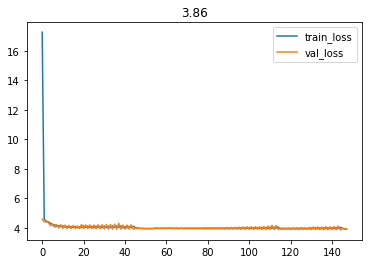

0it [00:00, ?it/s]

In [ ]:
#!g1.1
epochs = 50000

net = Converter(x_dim, hidden_dim, num_heads, pNumber).double().to(device)
opt = torch.optim.RMSprop(net.parameters(), lr=1e-4)

sig = 0.05
train_loss = []
val_loss = []
best_loss = np.Inf
grad_clip = 3
for epoch in range(epochs):
    loss1 = 0
    net.train()
    for i, xp1 in tqdm(enumerate(train_loader)):
        x1, p1 = xp1[0].to(device), xp1[1].to(device)
        opt.zero_grad()
        pred_x, v = net(x1, p1)
        batch_size = x1.size(0)
        loss = KLD(x1, p1, pred_x, sig)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(net.parameters(), grad_clip)
        opt.step()
        loss1 += loss.item()

    train_loss.append(loss1/(i+1))
    loss1 = 0
    net.eval()
    for i, xp1 in enumerate(val_loader):
        with torch.no_grad():
            x1, p1 = xp1[0].to(device), xp1[1].to(device)
            batch_size = x1.size(0)
            pred_x, v = net(x1, p1)
            loss = KLD(x1, p1, pred_x, sig)
            loss1 += loss.item()

    val_loss.append(loss1/(i+1))
    print(epoch, train_loss[-1], val_loss[-1])
    if val_loss[-1] < best_loss:
        best_loss = val_loss[-1]
        state = {
            'epoch': epoch + 1,
            'state_dict': net.state_dict(),
            'optimizer': opt.state_dict(),
        }
        torch.save(state, 'att_model.ptm')
    clear_output(True)
    plt.figure()
    plt.title(str(np.round(best_loss, 2)))
    plt.plot((train_loss), label='train_loss')
    plt.plot((val_loss), label='val_loss')
    plt.legend()
    plt.show()

In [ ]:
#!g1.1
def load_checkpoint(filepath='att_model.ptm'):
    checkpoint = torch.load(filepath)
    print('epoch: ', checkpoint['epoch'])
    net.load_state_dict(checkpoint['state_dict'])
    for p in net.parameters():
        p.requires_grad = False
    net.eval()
    return net

net_read = Converter(x_dim, hidden_dim, num_heads, pNumber).double().to(device)
net_read = load_checkpoint()

net_read.eval()
loss1 = 0
for i, xp1 in enumerate(test_loader):
    with torch.no_grad():
        x1, p1 = xp1[0].to(device), xp1[1].to(device)
        batch_size = x1.size(0)
        pred_x, v = net_read(x1, p1)
        loss = KLD(x1, p1, pred_x, sig)
        loss1 += loss.item()
print('test loss', loss1 / (i+1))

torch.Size([20]) torch.Size([20])


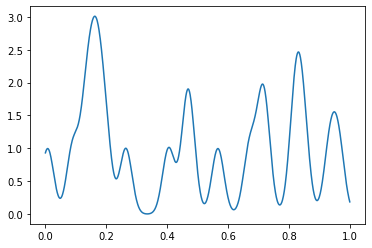

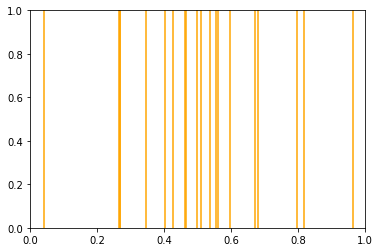

In [1024]:
#!g1.1
indx = 0
y_pred = pred_x.detach().cpu()[indx].flatten()
y_inp = x1.detach().cpu()[indx].flatten()
pp1 = p1.exp().detach().cpu()[indx].flatten()
z = (1/20*np.exp(-((y_inp[:, np.newaxis]-np.linspace(0, 1, 1000))**2) / (2*sig**2))/(sig * (2*np.pi)**0.5)).sum(axis=0)
print(y_pred.shape, y_inp.shape)

plt.plot(np.linspace(0, 1, 1000), z)
plt.figure()
for i in range(20):
    plt.axvline(x=y_corr[i], color='orange')
    plt.xlim(0, 1)

In [1023]:
#!g1.1
y_corr = (y_pred - 0.711) / (0.732 - 0.711)
d1 = KLD(y_inp.view(1, 20, 1), pp1.log().view(1, 20), y_pred.view(1, 20, 1), sig)
d2 = KLD(y_inp.view(1, 20, 1), pp1.log().view(1, 20), y_corr.view(1, 20, 1), sig)

(tensor(3.1586, dtype=torch.float64), tensor(4.3133, dtype=torch.float64))

In [1028]:
#!g1.1
y1 = y_inp.view(1, 20, 1)
p1 = pp1.log().view(1, 20)
y2 = y_pred.view(1, 20, 1)
y3 = y_corr.view(1, 20, 1)
d11 = (torch.exp(p1.view(1, 20, 1) - net.square_dist(y1, y2) / (2 * sig**2))).sum(dim=1)
d22 = (torch.exp(p1.view(1, 20, 1) - net.square_dist(y1, y3) / (2 * sig**2))).sum(dim=1)
0.5 * np.log(2 * np.pi) - d11.log().mean(), 0.5 * np.log(2 * np.pi) - d22.log().mean()

(tensor(3.1586, dtype=torch.float64), tensor(4.3133, dtype=torch.float64))

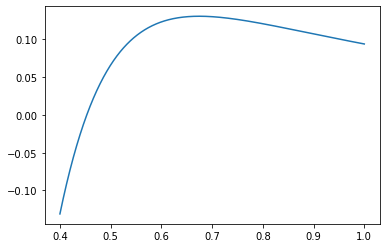

In [1053]:
#!g1.1
s = torch.linspace(0.4, 1, 1000)
plt.plot(s, -torch.log(1+(-0.5/s**2).exp())+torch.log(2*(-0.125/s**2).exp()))

In [1032]:
#!g1.1
d11.mean(), d22.mean()

(tensor(0.1067, dtype=torch.float64), tensor(0.0472, dtype=torch.float64))

In [ ]:
#!g1.1
